### FCNN

/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for deta

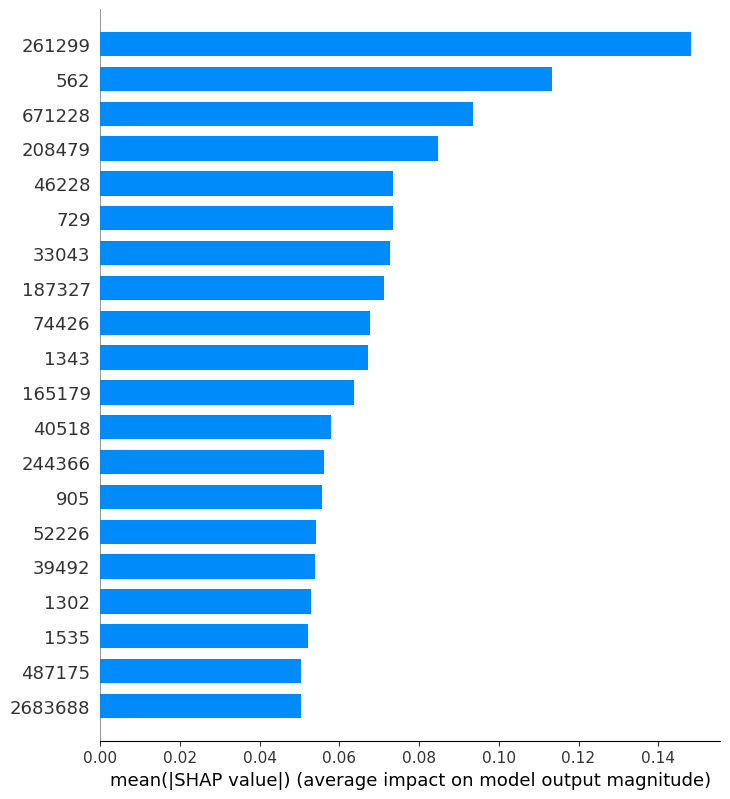

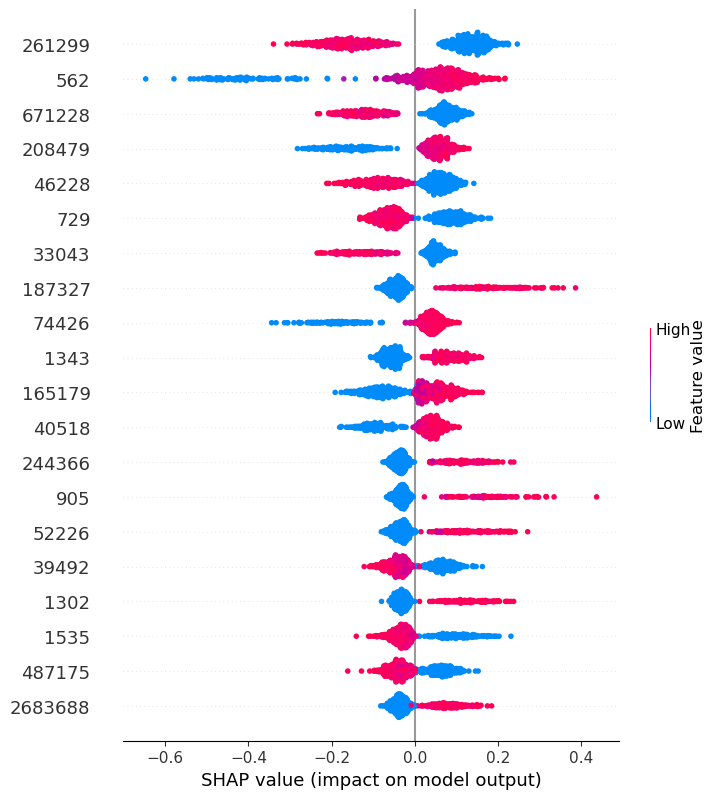

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shap
import torch

# Ensure the SHAP plots display inline in Jupyter Notebook
%matplotlib inline

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)
    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]


def get_data(file_path, metadata_file_path):
    """
    Load and merge metadata and relative abundance data for training.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Paths to data and model files
train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path = "MetaCardis_data/train_T2D_metadata.csv"
feature_columns_path = "Results/FCNN_plots/feature_columns.csv"

# Load merged data
merged_data = get_data(train_abundance_path, train_metadata_path)

# Define feature columns
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

# Load the species ID mapping
species_ids_path = "Default_Database/species_ids.csv"
species_df = pd.read_csv(species_ids_path)

# Create a mapping from taxon_id to species name
taxon_to_species = dict(zip(species_df['taxon_id'].astype(str), species_df['species']))

# Replace taxon IDs with species names in feature_columns
feature_columns_with_species = [
    taxon_to_species.get(taxon_id, taxon_id) for taxon_id in feature_columns
]

X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# List to store SHAP values from each fold
shap_values_list = []

# Load SHAP values from each fold
for fold in range(1, 6):
    shap_df = pd.read_csv(f"Results/FCNN_plots/shap_values_fold{fold}.csv")
    shap_values_list.append(shap_df.values)

# Convert the list to a NumPy array and calculate the average
shap_values_avg = np.mean(shap_values_list, axis=0)

# Save the averaged SHAP values
avg_shap_df = pd.DataFrame(shap_values_avg, columns=feature_columns)
avg_shap_df.to_csv("Results/FCNN_plots/avg_shap_values.csv", index=False)

# Save SHAP summary bar plot
shap.summary_plot(
    shap_values_avg, 
    X, 
    feature_names=feature_columns_with_species, 
    plot_type="bar", 
    show=False
)
plt.savefig("Results/FCNN_plots/shap_summary_bar_plot.png", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot

# Save SHAP summary plot
shap.summary_plot(
    shap_values_avg, 
    X, 
    feature_names=feature_columns_with_species, 
    show=False
)
plt.savefig("Results/FCNN_plots/shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot


# Display SHAP summary plot in the Jupyter notebook
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns, plot_type="bar")
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns)


In [2]:
species_to_check = ['457421', '908340', '29347', '638849', '360807', '1322', '817', '261299', '853', '88431', '40520', '39496', '39491', '39486', '1683', '218538', '301301', '410072', '657323', '39488', '1535'] 

In [5]:
# Compute mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_avg), axis=0)

# Create a dictionary mapping features to their mean absolute SHAP value
feature_importance_dict = {feature: mean_abs_shap for feature, mean_abs_shap in zip(feature_columns, mean_abs_shap_values)}

# Sort all features by their mean absolute SHAP value in descending order
sorted_all_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Create a mapping of feature names to their rank based on mean absolute SHAP values
feature_ranks = {feature: rank for rank, (feature, _) in enumerate(sorted_all_features, start=1)}

# Find the ranks of the specified features
print("Mean Absolute Importance Ranking of Specified Features in Total Features:")
for species in species_to_check:
    if species in feature_ranks:
        rank = feature_ranks[species]
        importance = feature_importance_dict[species]
        print(f"Feature {species} - Rank {rank} in Total Features, Mean Absolute Importance: {importance:.4f}")
    else:
        print(f"Feature {species} - Not found in the total features.")


Mean Absolute Importance Ranking of Specified Features in Total Features:
Feature 457421 - Rank 85 in Total Features, Mean Absolute Importance: 0.0192
Feature 908340 - Rank 123 in Total Features, Mean Absolute Importance: 0.0150
Feature 29347 - Rank 64 in Total Features, Mean Absolute Importance: 0.0254
Feature 638849 - Rank 68 in Total Features, Mean Absolute Importance: 0.0242
Feature 360807 - Rank 44 in Total Features, Mean Absolute Importance: 0.0339
Feature 1322 - Rank 93 in Total Features, Mean Absolute Importance: 0.0184
Feature 817 - Rank 41 in Total Features, Mean Absolute Importance: 0.0362
Feature 261299 - Rank 1 in Total Features, Mean Absolute Importance: 0.1481
Feature 853 - Rank 170 in Total Features, Mean Absolute Importance: 0.0100
Feature 88431 - Rank 92 in Total Features, Mean Absolute Importance: 0.0185
Feature 40520 - Rank 121 in Total Features, Mean Absolute Importance: 0.0151
Feature 39496 - Rank 53 in Total Features, Mean Absolute Importance: 0.0297
Feature 3949

### MicroKPNN_encoder_confounder_free

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shap
import torch

# Ensure the SHAP plots display inline in Jupyter Notebook
%matplotlib inline

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)
    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]


def get_data(file_path, metadata_file_path):
    """
    Load and merge metadata and relative abundance data for training.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Paths to data and model files
train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path = "MetaCardis_data/train_T2D_metadata.csv"
feature_columns_path = "Results/MicroKPNN_encoder_confounder_free_plots/feature_columns.csv"

# Load merged data
merged_data = get_data(train_abundance_path, train_metadata_path)

# Define feature columns
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

# Load the species ID mapping
species_ids_path = "Default_Database/species_ids.csv"
species_df = pd.read_csv(species_ids_path)

# Create a mapping from taxon_id to species name
taxon_to_species = dict(zip(species_df['taxon_id'].astype(str), species_df['species']))

# Replace taxon IDs with species names in feature_columns
feature_columns_with_species = [
    taxon_to_species.get(taxon_id, taxon_id) for taxon_id in feature_columns
]


X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# List to store SHAP values from each fold
shap_values_list = []

# Load SHAP values from each fold
for fold in range(1, 6):
    shap_df = pd.read_csv(f"Results/MicroKPNN_encoder_confounder_free_plots/shap_values_fold{fold}.csv")
    shap_values_list.append(shap_df.values)

# Convert the list to a NumPy array and calculate the average
shap_values_avg = np.mean(shap_values_list, axis=0)

# Save the averaged SHAP values
avg_shap_df = pd.DataFrame(shap_values_avg, columns=feature_columns)
avg_shap_df.to_csv("Results/MicroKPNN_encoder_confounder_free_plots/avg_shap_values.csv", index=False)

# Save SHAP summary bar plot
shap.summary_plot(
    shap_values_avg, 
    X, 
    feature_names=feature_columns_with_species, 
    plot_type="bar", 
    show=False
)
plt.savefig("Results/MicroKPNN_encoder_confounder_free_plots/shap_summary_bar_plot.png", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot

# Save SHAP summary plot
shap.summary_plot(
    shap_values_avg, 
    X, 
    feature_names=feature_columns_with_species, 
    show=False
)
plt.savefig("Results/MicroKPNN_encoder_confounder_free_plots/shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot

# # Display SHAP summary plot in the Jupyter notebook
# shap.summary_plot(shap_values_avg, X, feature_names=feature_columns, plot_type="bar")
# shap.summary_plot(shap_values_avg, X, feature_names=feature_columns)


/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for deta

In [2]:
species_to_check = ['457421', '908340', '29347', '638849', '360807', '1322', '817', '261299', '853', '88431', '40520', '39496', '39491', '39486', '1683', '218538', '301301', '410072', '657323', '39488', '1535'] 

In [3]:
# Compute mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_avg), axis=0)

# Create a dictionary mapping features to their mean absolute SHAP value
feature_importance_dict = {feature: mean_abs_shap for feature, mean_abs_shap in zip(feature_columns, mean_abs_shap_values)}

# Sort all features by their mean absolute SHAP value in descending order
sorted_all_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Create a mapping of feature names to their rank based on mean absolute SHAP values
feature_ranks = {feature: rank for rank, (feature, _) in enumerate(sorted_all_features, start=1)}

# Find the ranks of the specified features
print("Mean Absolute Importance Ranking of Specified Features in Total Features:")
for species in species_to_check:
    if species in feature_ranks:
        rank = feature_ranks[species]
        importance = feature_importance_dict[species]
        print(f"Feature {species} - Rank {rank} in Total Features, Mean Absolute Importance: {importance:.4f}")
    else:
        print(f"Feature {species} - Not found in the total features.")


Mean Absolute Importance Ranking of Specified Features in Total Features:
Feature 457421 - Rank 349 in Total Features, Mean Absolute Importance: 0.0000
Feature 908340 - Rank 128 in Total Features, Mean Absolute Importance: 0.0116
Feature 29347 - Rank 102 in Total Features, Mean Absolute Importance: 0.0180
Feature 638849 - Rank 19 in Total Features, Mean Absolute Importance: 0.0854
Feature 360807 - Rank 56 in Total Features, Mean Absolute Importance: 0.0376
Feature 1322 - Rank 144 in Total Features, Mean Absolute Importance: 0.0092
Feature 817 - Rank 23 in Total Features, Mean Absolute Importance: 0.0736
Feature 261299 - Rank 26 in Total Features, Mean Absolute Importance: 0.0698
Feature 853 - Rank 85 in Total Features, Mean Absolute Importance: 0.0230
Feature 88431 - Rank 50 in Total Features, Mean Absolute Importance: 0.0432
Feature 40520 - Rank 239 in Total Features, Mean Absolute Importance: 0.0028
Feature 39496 - Rank 83 in Total Features, Mean Absolute Importance: 0.0238
Feature 3

list of species confounded by metformin in paper "A realistic benchmark for differential abundance testing and confounder adjustment in human microbiome studies"

In [ ]:
species_to_check = ['457421', '908340', '29347', '638849', '360807', '1322', '817', '261299', '853', '88431', '40520', '39496', '39491', '39486', '1683', '218538', '301301', '410072', '657323', '39488', '1535', ]  # Replace with actual species names

we can see if we use fcnn without removing metformin effect species 1535 and 261299 a re in the top 20 important features which is bases i nthe paper "A realistic benchmark for differential abundance testing and confounder adjustment in human microbiome studies" they are associated by metformin and not the T2D. but we can see that they are not in out model important features.

#### First layer

/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for deta

X shape: (671, 371)
Mask shape: torch.Size([415, 371])

=== Loading model fold 1: Results/MicroKPNN_encoder_confounder_free_plots/trained_model1.pth ===


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl


=== Loading model fold 2: Results/MicroKPNN_encoder_confounder_free_plots/trained_model2.pth ===

=== Loading model fold 3: Results/MicroKPNN_encoder_confounder_free_plots/trained_model3.pth ===

=== Loading model fold 4: Results/MicroKPNN_encoder_confounder_free_plots/trained_model4.pth ===

=== Loading model fold 5: Results/MicroKPNN_encoder_confounder_free_plots/trained_model5.pth ===


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

hidden_avg shape: (671, 415)
shap_avg shape: (671, 415)
Saved averaged hidden activations and SHAP values to CSV.
{'0': '0', '1': '1', '2': '10', '3': '11', '4': '12', '5': '12-EthanediolEthyleneglycolProductionexport', '6': '12-propanediolPropenediolPropyleneglycolR-12-propanediolR-propane-12-diolS-12-propanediolS-propane-12-diolConsumptionimport', '7': '12-propanediolPropenediolPropyleneglycolR-12-propanediolR-propane-12-diolS-12-propanediolS-propane-12-diolProductionexport', '8': '13', '9': '13-PropanediolProductionexport', '10': '14', '11': '147', '12': '148', '13': '153', '14': '16', '15': '17', '16': '18', '17': '182', '18': '19', '19': '2', '20': '2-OxobutyrateAlpha-ketobutyrate2-OxobutanoateConsumptionimport', '21': '2-methylbutyrate2-methylbutanoicacidConsumptionimport', '22': '21', '23': '22', '24': '228', '25': '24', '26': '272', '27': '29', '28': '3', '29': '30', '30': '37', '31': '39', '32': '4', '33': '4-Aminobenzoatepara-aminoBenzoicacidConsumptionimport', '34': '4-Amino

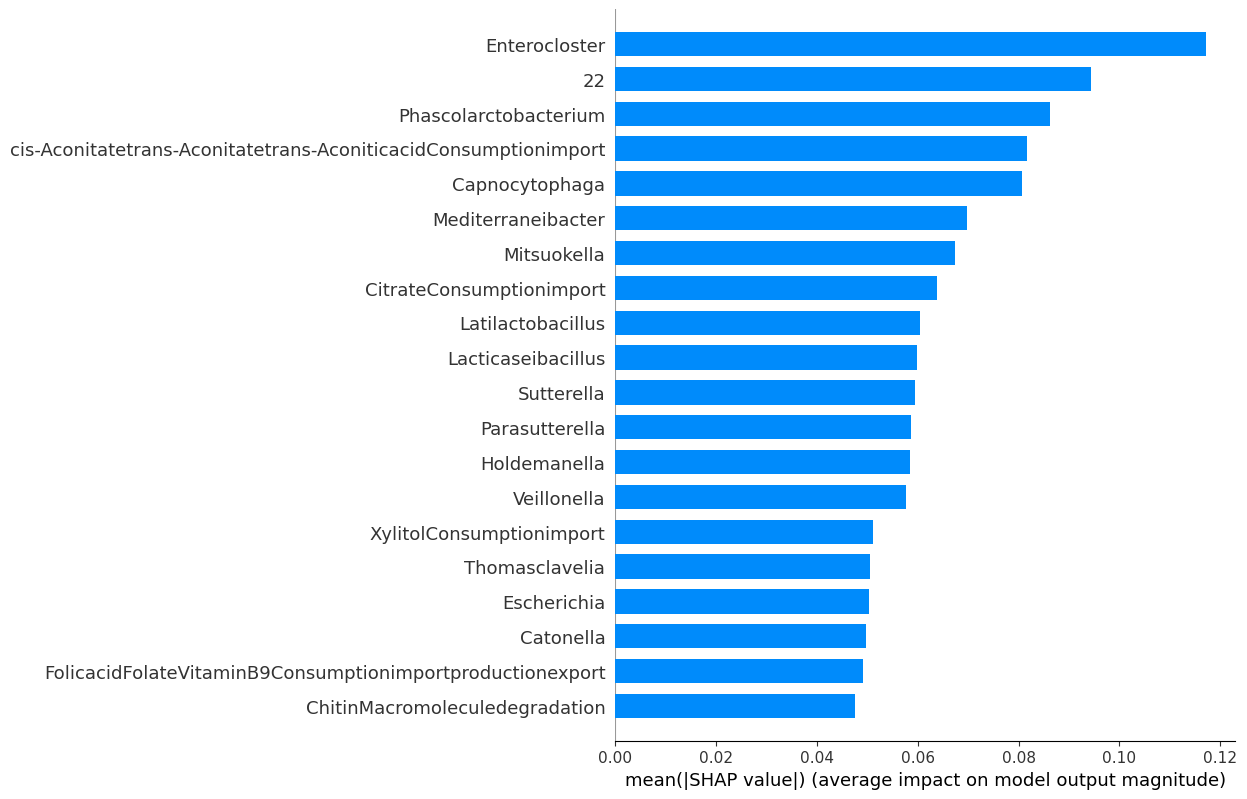

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Done! Displayed bar + swarm summary for the averaged first-layer SHAP.


In [0]:
##########################################
# JUPYTER NOTEBOOK CELL 1: Imports
##########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import torch

# If you're in a Jupyter environment, ensure inline plotting:
%matplotlib inline

##########################################
# JUPYTER NOTEBOOK CELL 2: Build Mask
##########################################
def build_mask(edge_list, species):
    # generate the mask
    edge_df = pd.read_csv(edge_list)
    
    edge_df['parent'] = edge_df['parent'].astype(str)
    parent_nodes = sorted(set(edge_df['parent'].tolist()))  # Sort to ensure consistent order
    mask = torch.zeros(len(species), len(parent_nodes))
    child_nodes = species

    parent_dict = {k: i for i, k in enumerate(parent_nodes)}
    child_dict = {k: i for i, k in enumerate(child_nodes)}
    
    for i, row in edge_df.iterrows():
        if row['child'] != 'Unnamed: 0': 
            mask[child_dict[str(row['child'])]][parent_dict[row['parent']]] = 1

    return mask.T

##########################################
# JUPYTER NOTEBOOK CELL 3: Data loading
##########################################
def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, 
    and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values

    # Example transformations
    X_log = np.log(X + 1)

    # Optionally standard-scale
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)

    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def get_data(file_path, metadata_file_path):
    """
    Merge metadata and transformed abundance data by SampleID.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')
    return merged_data

##########################################
# JUPYTER NOTEBOOK CELL 4: Model & Helpers
##########################################
# We'll import or define your GAN model with the MaskedLinear
from MicroKPNN_encoder_confounder_free_lib.models import *  # Make sure models.py is in your path, or paste the definition

def get_first_hidden_activations(model, x):
    """
    Forward pass x through the first hidden layer:
      - encoder[0]: MaskedLinear
      - encoder[1]: BatchNorm
      - encoder[2]: ReLU
    Return shape: [batch_size, hidden_dim_of_first_layer]
    """
    out = model.encoder[0](x)
    out = model.encoder[1](out)
    out = model.encoder[2](out)
    return out

##########################################
# JUPYTER NOTEBOOK CELL 5: Set Up Paths
##########################################

train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path   = "MetaCardis_data/train_T2D_metadata.csv"
edge_list_path        = "Default_Database/EdgeList.csv"
model_prefix          = "Results/MicroKPNN_encoder_confounder_free_plots/trained_model"
shap_csv_prefix       = "Results/MicroKPNN_encoder_confounder_free_plots/shap_values_first_hidden_fold"

feature_columns_path  = "Results/MicroKPNN_encoder_confounder_free_plots/feature_columns.csv"

num_folds = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# JUPYTER NOTEBOOK CELL 6: Load Data + Mask
##########################################
merged_data = get_data(train_abundance_path, train_metadata_path)

# 1) Figure out the "feature columns" to keep
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns  = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

# 2) Build X
X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
print("X shape:", X.shape)

# 3) Build the mask
#    We read the original abundance CSV (untransformed) for 'species' if needed:
raw_abundance_df = pd.read_csv(train_abundance_path, index_col=0)
species = raw_abundance_df.columns.values.tolist()

mask = build_mask(edge_list_path, species)
print("Mask shape:", mask.shape)

##########################################
# JUPYTER NOTEBOOK CELL 7: Collect SHAP + Activations
##########################################
hidden_list = []
shap_list   = []
node_names  = None

for fold in range(1, num_folds + 1):
    # 1) Load model
    model_path = f"{model_prefix}{fold}.pth"
    print(f"\n=== Loading model fold {fold}: {model_path} ===")

    base_model = GAN(mask=mask).to(device)
    state_dict = torch.load(model_path, map_location=device)
    base_model.load_state_dict(state_dict)
    base_model.eval()

    # 2) Forward pass => first hidden-layer
    with torch.no_grad():
        hidden_activations = get_first_hidden_activations(base_model, X_tensor)
    hidden_activations_np = hidden_activations.cpu().numpy()
    hidden_list.append(hidden_activations_np)

    # 3) Load SHAP for fold => shape [N, d_hidden]
    shap_csv_path = f"{shap_csv_prefix}{fold}.csv"
    shap_df = pd.read_csv(shap_csv_path)
    shap_values_np = shap_df.values
    shap_list.append(shap_values_np)

    # Save column names if first time
    if node_names is None:
        node_names = shap_df.columns.tolist()

##########################################
# JUPYTER NOTEBOOK CELL 8: Average Over Folds
##########################################
# Stack => shape (num_folds, N, d_hidden)
hidden_array = np.stack(hidden_list, axis=0)  # [5, N, d_hidden]
shap_array   = np.stack(shap_list, axis=0)    # [5, N, d_hidden]

hidden_avg = hidden_array.mean(axis=0)        # [N, d_hidden]
shap_avg   = shap_array.mean(axis=0)          # [N, d_hidden]

print("hidden_avg shape:", hidden_avg.shape)
print("shap_avg shape:",   shap_avg.shape)

##########################################
# JUPYTER NOTEBOOK CELL 9: (Optional) Save Averages
##########################################
avg_hidden_df = pd.DataFrame(hidden_avg, columns=node_names)
avg_hidden_df.to_csv("Results/MicroKPNN_encoder_confounder_free_plots/avg_hidden_activations_first_layer.csv", index=False)

avg_shap_df = pd.DataFrame(shap_avg, columns=node_names)
avg_shap_df.to_csv("Results/MicroKPNN_encoder_confounder_free_plots/avg_shap_values_first_layer.csv", index=False)

print("Saved averaged hidden activations and SHAP values to CSV.")


parent_dict_path = "Results/MicroKPNN_encoder_confounder_free_plots/parent_dict.csv"
parents_df = pd.read_csv(parent_dict_path)

# Create a mapping from taxon_id to species name
id_to_names = dict(zip(parents_df['value'].astype(str), parents_df['key']))
print(id_to_names)

# Replace taxon IDs with species names in feature_columns
hidden_columns_with_names = [
    id_to_names.get(node.replace("Node_", ""), node) for node in node_names
]

print(node_names)

print(hidden_columns_with_names)

##########################################
# JUPYTER NOTEBOOK CELL 10: Final SHAP Plots
##########################################
plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_avg,       # shape [N, d_hidden], the SHAP values
    hidden_avg,     # shape [N, d_hidden], the actual hidden activations
    feature_names=hidden_columns_with_names,
    plot_type="bar",
    show = False
)
plt.savefig("Results/MicroKPNN_encoder_confounder_free_plots/shap_summary_plot_hidden.png", dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_avg,
    hidden_avg,
    feature_names=hidden_columns_with_names,
    plot_type="dot"
)

plt.show()

print("Done! Displayed bar + swarm summary for the averaged first-layer SHAP.")


29,355

L-IsoleucineIsoleucineConsumptionimport,401

Phascolarctobacterium,254

H2HydrogenConsumptionimport,183

2-OxobutyrateAlpha-ketobutyrate2-OxobutanoateConsumptionimport,320

Chondroitin4-sulfateChondroitin6-sulfateMacromoleculedegradation,193

ChenodeoxycholicacidChenodeoxycholateConsumptionimport,34

Solobacterium,219

PyruvateConsumptionimport,341

Inositolmyo-InositolInositol1-phosphateMyo-inositolphosphateConsumptionimport,102

NiacinVitaminB3NicotinicacidNicotinateNicotinamideVitaminB3Consumptionimportproductionexport,316

2-methylbutyrate2-methylbutanoicacidConsumptionimport,98

N-AcetylneuraminicacidN-acetylneuraminateNeu5AcSialicacidConsumptionimport,298

RiboflavinVitaminB2Consumptionimportproductionexport,293

Lautropia,63

N-Acetyl-D-GlucosamineN-AcetylglucosamineConsumptionimport,223

Scardovia,168

LactoseConsumptionimport,287

Parasutterella,343

MethaneCH4Productionexport,279


# Not correct Yet

Comparison of imrtance score between FCNN and our model (MicroKPNN_encoder_confounder_free)

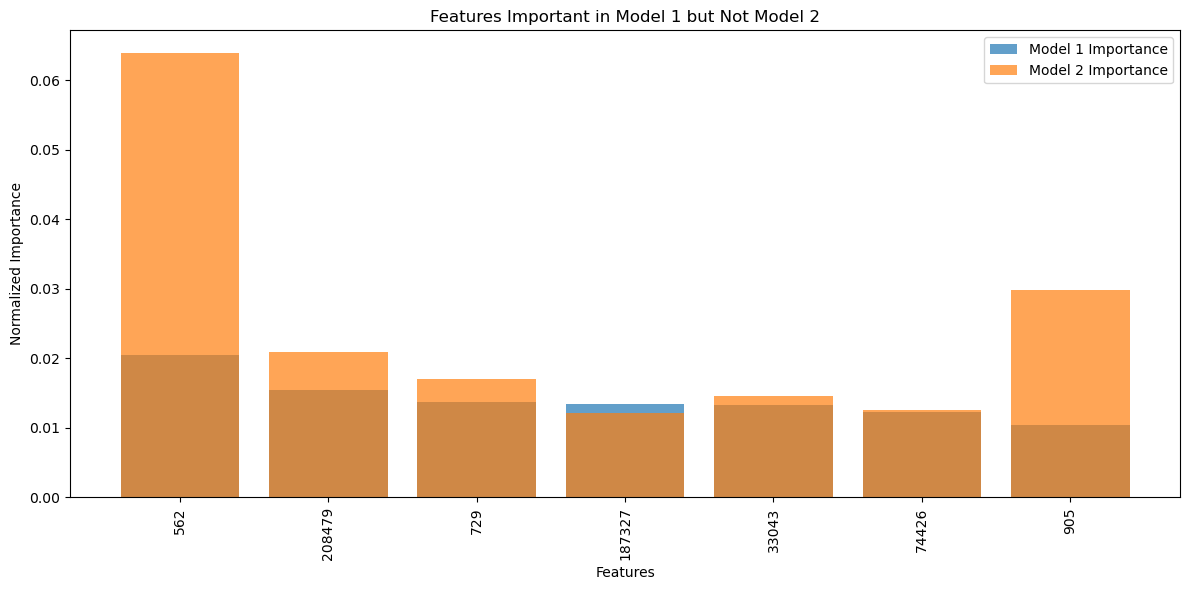

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load average SHAP values for both models
avg_shap_model1 = pd.read_csv("Results/FCNN_plots/avg_shap_values.csv")
avg_shap_model2 = pd.read_csv("Results/MicroKPNN_encoder_confounder_free_plots/avg_shap_values.csv")

# Normalize SHAP values for comparability
model1_normalized = avg_shap_model1.abs().div(avg_shap_model1.abs().sum(axis=1), axis=0)
model2_normalized = avg_shap_model2.abs().div(avg_shap_model2.abs().sum(axis=1), axis=0)

# Compute mean normalized SHAP values for each feature
model1_mean_importance = model1_normalized.mean(axis=0)
model2_mean_importance = model2_normalized.mean(axis=0)

# Set a threshold for low SHAP values
threshold = 0.01

# Identify important features in Model 1 but not Model 2
important_in_model1 = model1_mean_importance[model1_mean_importance > threshold].index
unimportant_in_model2 = model2_mean_importance[model2_mean_importance <= threshold].index

unique_to_model1 = set(important_in_model1) - set(unimportant_in_model2)

# Create a DataFrame for visualization
unique_model1_df = pd.DataFrame({
    "Feature": list(unique_to_model1),
    "Model 1 Importance": model1_mean_importance[list(unique_to_model1)].values,
    "Model 2 Importance": model2_mean_importance[list(unique_to_model1)].values,
})

# Sort by Model 1 Importance for better visualization
unique_model1_df = unique_model1_df.sort_values(by="Model 1 Importance", ascending=False)

# Plot features unique to Model 1
plt.figure(figsize=(12, 6))
plt.bar(unique_model1_df["Feature"], unique_model1_df["Model 1 Importance"], label="Model 1 Importance", alpha=0.7)
plt.bar(unique_model1_df["Feature"], unique_model1_df["Model 2 Importance"], label="Model 2 Importance", alpha=0.7)
plt.xticks(rotation=90)
plt.title("Features Important in Model 1 but Not Model 2")
plt.xlabel("Features")
plt.ylabel("Normalized Importance")
plt.legend()
plt.tight_layout()
plt.show()


### FCNN_encoder_confounder_free

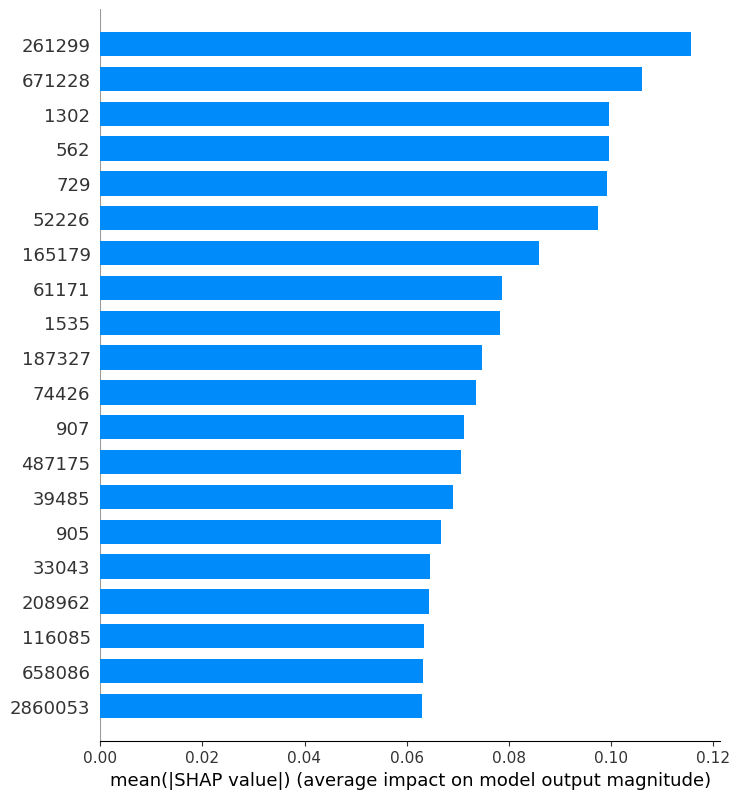

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


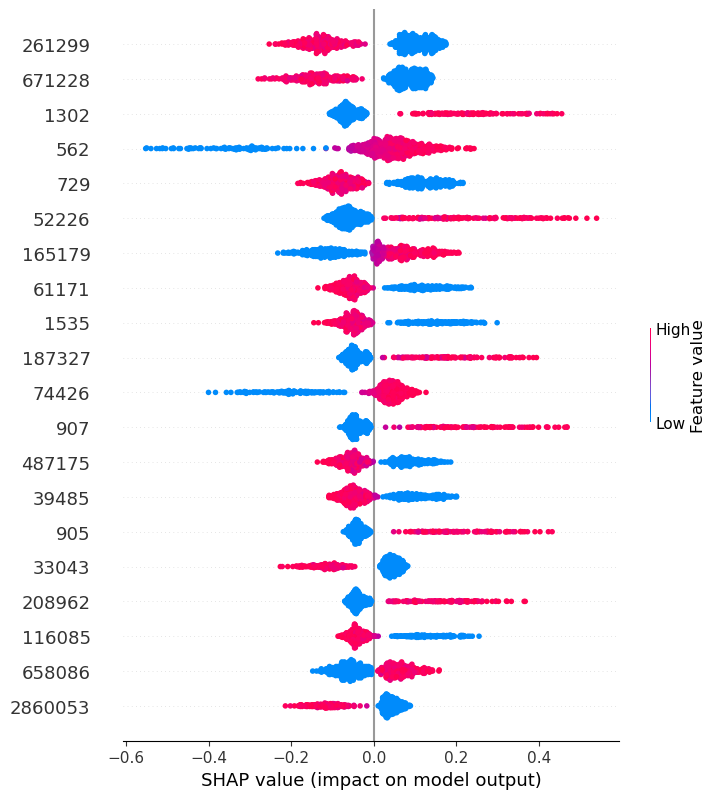

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shap
import torch

# Ensure the SHAP plots display inline in Jupyter Notebook
%matplotlib inline

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply log transformation, and return transformed DataFrame with 'SampleID'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(X_log)
    X_log_df = pd.DataFrame(features_normalized, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]


def get_data(file_path, metadata_file_path):
    """
    Load and merge metadata and relative abundance data for training.
    """
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)

    # Merge metadata and relative abundance data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    return merged_data

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Paths to data and model files
train_abundance_path = "MetaCardis_data/new_train_T2D_abundance_with_taxon_ids.csv"
train_metadata_path = "MetaCardis_data/train_T2D_metadata.csv"
feature_columns_path = "Results/FCNN_encoder_confounder_free_plots/feature_columns.csv"

# Load merged data
merged_data = get_data(train_abundance_path, train_metadata_path)

# Define feature columns
metadata_columns = pd.read_csv(train_metadata_path).columns.tolist()
feature_columns = pd.read_csv(feature_columns_path, header=None).squeeze("columns").astype(str).tolist()

X = merged_data[feature_columns].values
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# List to store SHAP values from each fold
shap_values_list = []

# Load SHAP values from each fold
for fold in range(1, 6):
    shap_df = pd.read_csv(f"Results/FCNN_encoder_confounder_free_plots/shap_values_fold{fold}.csv")
    shap_values_list.append(shap_df.values)

# Convert the list to a NumPy array and calculate the average
shap_values_avg = np.mean(shap_values_list, axis=0)

# Save the averaged SHAP values
avg_shap_df = pd.DataFrame(shap_values_avg, columns=feature_columns)
avg_shap_df.to_csv("Results/FCNN_encoder_confounder_free_plots/avg_shap_values.csv", index=False)

# Display SHAP summary plot in the Jupyter notebook
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns, plot_type="bar")
shap.summary_plot(shap_values_avg, X, feature_names=feature_columns)


### comparison 

features that are importsnt in the fcnn but not important in the fcnn_encpoder_confounder_free. 
* Interpret the Results

**High Positive Differences**: These indicate features where the confounded model (Model 1) assigns much higher importance compared to the confounder-free model (Model 2). This suggests that these features may be influenced by the confounder (e.g., Metformin).

**Low or No Differences**: Features with little to no difference are likely not affected by the confounder.

In [12]:
import pandas as pd
import numpy as np

# Load SHAP values for the first model (confounded)
shap_df_model1 = pd.read_csv("Results/FCNN_plots/avg_shap_values.csv")

# Load SHAP values for the second model (confounder-free)
shap_df_model2 = pd.read_csv("Results/FCNN_encoder_confounder_free_plots/avg_shap_values.csv")

# Load feature names
feature_columns = shap_df_model1.columns.tolist()


In [13]:
# Mean absolute SHAP values for each feature in both models
mean_abs_shap_model1 = shap_df_model1.abs().mean(axis=0)
mean_abs_shap_model2 = shap_df_model2.abs().mean(axis=0)


In [14]:
# Calculate the difference in mean absolute SHAP values
shap_diff = mean_abs_shap_model1 - mean_abs_shap_model2

# Find features where the SHAP value difference is significant (e.g., above a threshold)
threshold = 0.001  # You can adjust this threshold based on your data
important_in_model1 = shap_diff[shap_diff > threshold]

# Display the features important in Model 1 but not in Model 2
print("Features important in Model 1 (confounded) but not in Model 2 (confounder-free):")
print(important_in_model1)


Features important in Model 1 (confounded) but not in Model 2 (confounder-free):
1660       0.004637
28117      0.004132
328814     0.009493
908612     0.006472
33037      0.001721
             ...   
384638     0.001146
261299     0.032539
245014     0.027662
2648384    0.003072
186928     0.001017
Length: 128, dtype: float64


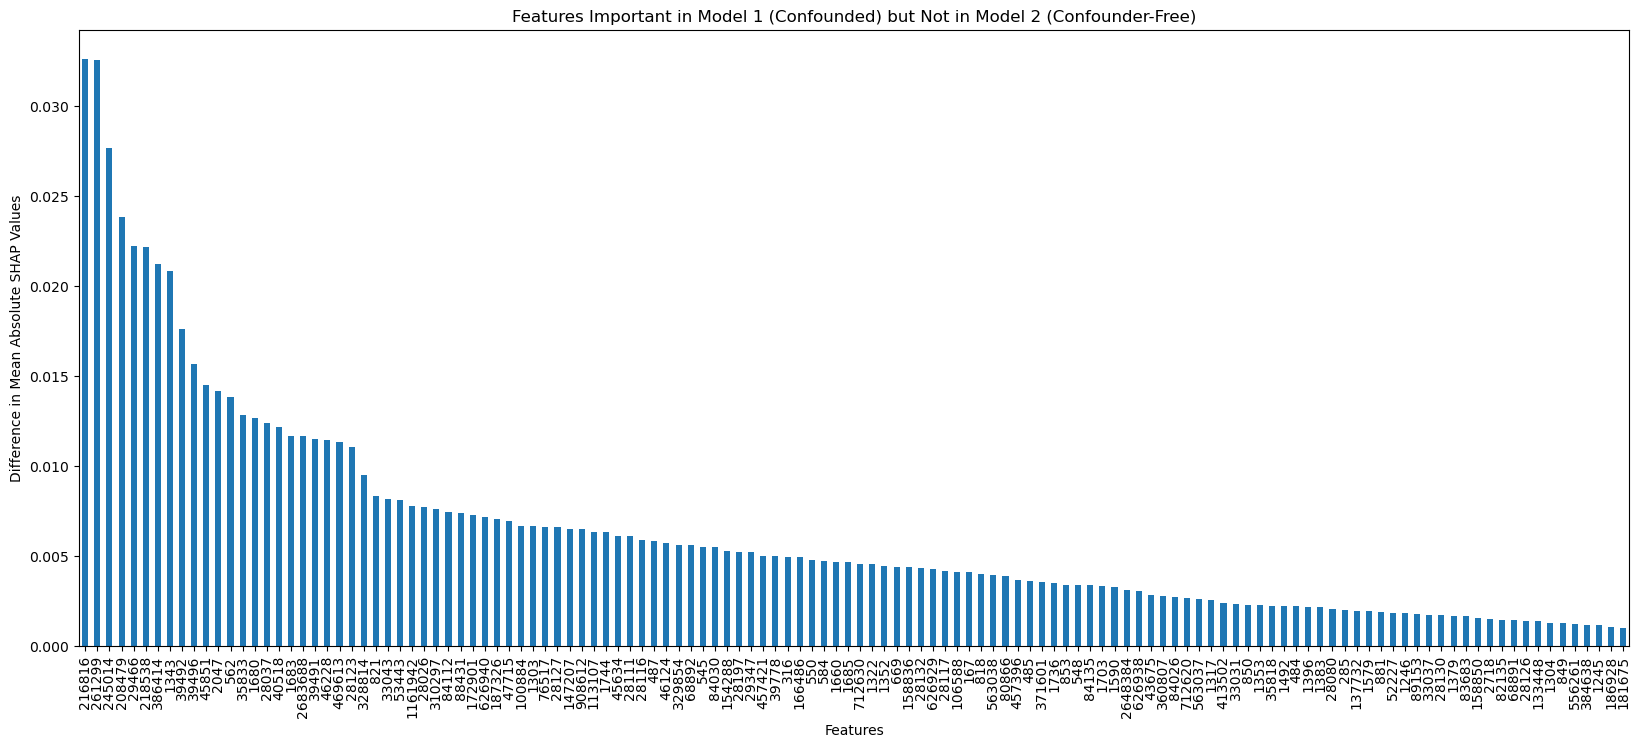

In [15]:
import matplotlib.pyplot as plt

# Sort the features by the difference in SHAP values
important_in_model1_sorted = important_in_model1.sort_values(ascending=False)

# Plot the differences
plt.figure(figsize=(20, 8))
important_in_model1_sorted.plot(kind='bar')
plt.title("Features Important in Model 1 (Confounded) but Not in Model 2 (Confounder-Free)")
plt.xlabel("Features")
plt.ylabel("Difference in Mean Absolute SHAP Values")
plt.show()


Check the ones that a realistic benchmark paper show as a sconfounded species

   Species  Model 1 (Confounded)  Model 2 (Confounder-Free)  Difference
0   457421              0.019205                   0.014218    0.004987
1   908340              0.014955                   0.019398   -0.004443
2    29347              0.025412                   0.020230    0.005182
3   638849              0.024166                   0.044453   -0.020287
4   360807              0.033880                   0.031140    0.002740
5     1322              0.018363                   0.013852    0.004511
6      817              0.036184                   0.041740   -0.005557
7   261299              0.148133                   0.115594    0.032539
8      853              0.009972                   0.006576    0.003395
9    88431              0.018470                   0.011092    0.007378
10   40520              0.015060                   0.036878   -0.021817
11   39496              0.029734                   0.014059    0.015676
12   39491              0.020149                   0.008680    0

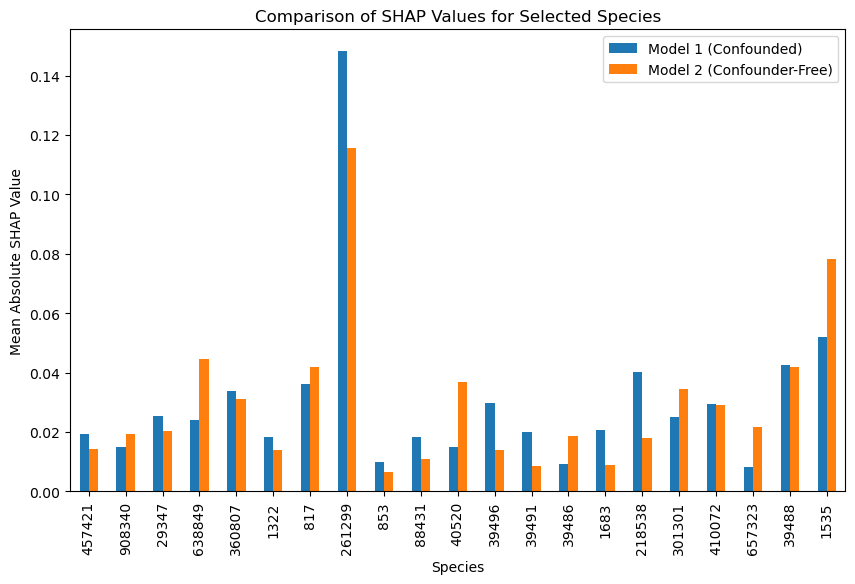

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load SHAP values for the confounded model
shap_df_model1 = pd.read_csv("Results/FCNN_plots/avg_shap_values.csv")

# Load SHAP values for the confounder-free model
shap_df_model2 = pd.read_csv("Results/FCNN_encoder_confounder_free_plots/avg_shap_values.csv")

# Load feature (species) names
feature_columns = pd.read_csv("Results/FCNN_plots/feature_columns.csv", header=None).squeeze("columns").astype(str).tolist()

# List of species you want to check
species_to_check = ['457421', '908340', '29347', '638849', '360807', '1322', '817', '261299', '853', '88431', '40520', '39496', '39491', '39486', '1683', '218538', '301301', '410072', '657323', '39488', '1535', ]  # Replace with actual species names

# Get the mean absolute SHAP values for the selected species in both models
mean_abs_shap_model1 = shap_df_model1.abs().mean(axis=0)
mean_abs_shap_model2 = shap_df_model2.abs().mean(axis=0)

# Filter the SHAP values for the selected species
shap_comparison = pd.DataFrame({
    'Species': species_to_check,
    'Model 1 (Confounded)': [mean_abs_shap_model1[species] for species in species_to_check],
    'Model 2 (Confounder-Free)': [mean_abs_shap_model2[species] for species in species_to_check]
})

# Calculate the difference
shap_comparison['Difference'] = shap_comparison['Model 1 (Confounded)'] - shap_comparison['Model 2 (Confounder-Free)']

# Display the comparison
print(shap_comparison)

# Plot the comparison
shap_comparison.set_index('Species')[['Model 1 (Confounded)', 'Model 2 (Confounder-Free)']].plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of SHAP Values for Selected Species")
plt.ylabel("Mean Absolute SHAP Value")
plt.show()


Species with Significant Differences in SHAP Values:
   Species  Difference   p-value  Significant
0   457421    0.002800  0.697317        False
1   908340    0.008924  0.265968        False
2    29347    0.011310  0.447588        False
3   638849   -0.015497  0.079486        False
4   360807    0.008906  0.485329        False
5     1322    0.009365  0.154735        False
6      817    0.004496  0.822233        False
7   261299    0.032725  0.099212        False
8      853    0.003357  0.464196        False
9    88431    0.010118  0.037295         True
10   40520   -0.012937  0.141191        False
11   39496    0.015529  0.084843        False
12   39491    0.012975  0.050563        False
13   39486    0.008331  0.142420        False
14    1683    0.017180  0.320006        False
15  218538    0.021676  0.068205        False
16  301301   -0.002967  0.478177        False
17  410072    0.008642  0.358018        False
18  657323   -0.001052  0.867243        False
19   39488    0.003233  0.8

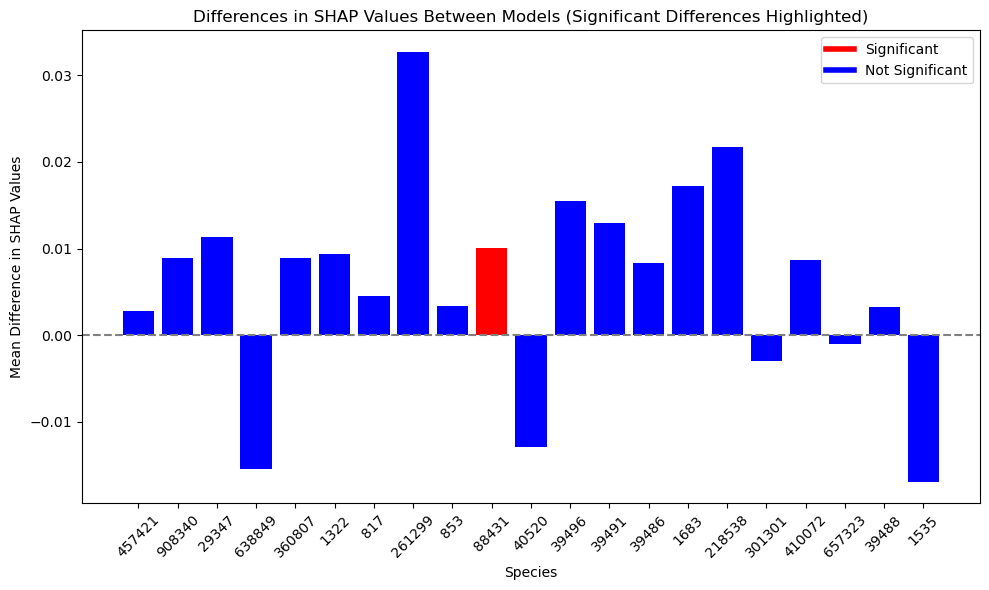

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# Load SHAP values for the confounded model (5 folds)
shap_values_model1 = [pd.read_csv(f"Results/FCNN_plots/shap_values_fold{fold}.csv").values for fold in range(1, 6)]

# Load SHAP values for the confounder-free model (5 folds)
shap_values_model2 = [pd.read_csv(f"Results/FCNN_encoder_confounder_free_plots/shap_values_fold{fold}.csv").values for fold in range(1, 6)]

# Load feature (species) names
feature_columns = pd.read_csv("Results/FCNN_plots/feature_columns.csv", header=None).squeeze("columns").astype(str).tolist()

# Convert SHAP values lists to NumPy arrays
shap_values_model1 = np.array(shap_values_model1)  # Shape: (5, num_samples, num_features)
shap_values_model2 = np.array(shap_values_model2)  # Shape: (5, num_samples, num_features)

# Calculate the mean absolute SHAP values for each fold and each feature
mean_abs_shap_model1 = np.abs(shap_values_model1).mean(axis=1)  # Shape: (5, num_features)
mean_abs_shap_model2 = np.abs(shap_values_model2).mean(axis=1)  # Shape: (5, num_features)

# List of species to check
species_to_check = ['457421', '908340', '29347', '638849', '360807', '1322', '817', '261299', '853', '88431', '40520', '39496', '39491', '39486', '1683', '218538', '301301', '410072', '657323', '39488', '1535', ]  # Replace with actual species names

# Perform paired t-test for each species
p_values = []
differences = []

for species in species_to_check:
    idx = feature_columns.index(species)
    diff = mean_abs_shap_model1[:, idx] - mean_abs_shap_model2[:, idx]
    differences.append(diff.mean())
    t_stat, p_val = ttest_rel(mean_abs_shap_model1[:, idx], mean_abs_shap_model2[:, idx])
    p_values.append(p_val)

# Create a DataFrame with results
results_df = pd.DataFrame({
    'Species': species_to_check,
    'Difference': differences,
    'p-value': p_values
})

# Add a significance column based on a threshold (e.g., 0.05)
results_df['Significant'] = results_df['p-value'] < 0.05

# Display the results
print("Species with Significant Differences in SHAP Values:")
print(results_df)

# Plot the differences with significance highlighted
plt.figure(figsize=(10, 6))
colors = ['red' if sig else 'blue' for sig in results_df['Significant']]
plt.bar(results_df['Species'], results_df['Difference'], color=colors)
plt.axhline(0, color='grey', linestyle='--')
plt.title("Differences in SHAP Values Between Models (Significant Differences Highlighted)")
plt.ylabel("Mean Difference in SHAP Values")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.legend(handles=[plt.Line2D([0], [0], color='red', lw=4, label='Significant'),
                    plt.Line2D([0], [0], color='blue', lw=4, label='Not Significant')])
plt.tight_layout()
plt.show()
